In [1]:
import numpy as np
import dynamo as dyn
import scanpy
import larry
import anndata

|-----> setting visualization default mode in dynamo. Your customized matplotlib settings might be overritten.


/Users/arasmuss/opt/anaconda3/lib/python3.9/site-packages/nxviz/__init__.py:18: UserWarning: 
nxviz has a new API! Version 0.7.3 onwards, the old class-based API is being
deprecated in favour of a new API focused on advancing a grammar of network
graphics. If your plotting code depends on the old API, please consider
pinning nxviz at version 0.7.3, as the new API will break your old code.

To check out the new API, please head over to the docs at
https://ericmjl.github.io/nxviz/ to learn more. We hope you enjoy using it!

(This deprecation message will go away in version 1.0.)

  warnings.warn(


In [2]:
# load in the anndata w/ results for the LARRY that were provided
adata = dyn.read_h5ad('control_invitro_larry_default2000genes_stochastic.h5ad')
adata

AnnData object with n_obs × n_vars = 139102 × 1999
    obs: 'Library', 'Cell barcode', 'time', 'Starting population', 'Cell type annotation', 'Well', 'SPRING-x', 'SPRING-y', 'gcs', 'cytotrace', 'counts', 'initial_size_spliced', 'initial_size_unspliced', 'initial_size', 'n_counts', 'clonei', 'clones', 'batch', 'velocity_self_transition'
    var: 'Accession', 'Chromosome', 'End', 'Start', 'Strand', 'cytotrace', 'cytotrace_corrs', 'gene_count_corr', 'means', 'dispersions', 'dispersions_norm', 'velocity_gamma', 'velocity_r2', 'velocity_genes'
    uns: 'Cell type annotation_colors', 'neighbors', 'pca', 'velocity_graph', 'velocity_graph_neg', 'velocity_settings'
    obsm: 'X_pca', 'X_spring', 'X_umap', 'spring', 'velocity_umap'
    varm: 'PCs'
    layers: 'Ms', 'Mu', 'ambiguous', 'matrix', 'spliced', 'unspliced', 'variance_velocity', 'velocity'
    obsp: 'connectivities', 'distances'

In [3]:
# I just put this in here to make the analysis easy on my local machine's memory (probably remove for final analysis)
scanpy.pp.highly_variable_genes(adata, n_top_genes=1250)
adata = adata[:, adata.var['highly_variable']]

In [4]:
# determine the names of the cells we're using for performance evaluation
fate_df = larry.tl.fetch_fate_bias_data()["fate_df"]
good_df = fate_df[fate_df.sum(1) > 0] # this is what you want (2,081)
index_starting = good_df.index.astype(int)

d2_adata = adata.obs.loc[adata.obs['time'] == 2]
starting_names = list(d2_adata.iloc[good_df.index.astype(int)].index)

In [5]:
# let's make a new AnnData without a lot of this stuff (I was getting errors when running on original adata)
adata_2 = anndata.AnnData(adata.X)
adata_2.obs.index = adata.obs.index
adata_2.obs['Cell barcode'] = adata.obs['Cell barcode'].values
adata_2.obs['Well'] = adata.obs['Well'].values
adata_2.obs['time'] = adata.obs['time'].values
adata_2.obs['Cell type annotation'] = adata.obs['Cell type annotation'].values
adata_2.layers['unspliced'] = adata.layers['unspliced']
adata_2.layers['spliced'] = adata.layers['spliced']
adata_2

AnnData object with n_obs × n_vars = 139102 × 1250
    obs: 'Cell barcode', 'Well', 'time', 'Cell type annotation'
    layers: 'unspliced', 'spliced'

In [1]:
# training data is only from well 0 and well 1. 
adata_training = adata_2[adata_2.obs['Well'].isin([1.0, 0.0])]

NameError: name 'adata_2' is not defined

In [7]:
# monocle preprocessing of the data
dyn.pp.recipe_monocle(adata_training)

|-----> recipe_monocle_keep_filtered_cells_key is None. Using default value from DynamoAdataConfig: recipe_monocle_keep_filtered_cells_key=True
|-----> recipe_monocle_keep_filtered_genes_key is None. Using default value from DynamoAdataConfig: recipe_monocle_keep_filtered_genes_key=True
|-----> recipe_monocle_keep_raw_layers_key is None. Using default value from DynamoAdataConfig: recipe_monocle_keep_raw_layers_key=True
|-----> apply Monocole recipe to adata...
|-----> <insert> pp to uns in AnnData Object.
|-----------> <insert> has_splicing to uns['pp'] in AnnData Object.
|-----------> <insert> has_labling to uns['pp'] in AnnData Object.
|-----------> <insert> splicing_labeling to uns['pp'] in AnnData Object.
|-----------> <insert> has_protein to uns['pp'] in AnnData Object.
|-----> ensure all cell and variable names unique.
|-----> ensure all data in different layers in csr sparse matrix format.
|-----> ensure all labeling data properly collapased
|-----------> <insert> tkey to uns['

/Users/arasmuss/opt/anaconda3/lib/python3.9/site-packages/anndata/compat/_overloaded_dict.py:106: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  self.data[key] = value


|-----? dynamo detects your data is size factor normalized and/or log transformed. If this is not right, plese set `normalized = False.
|-----> filtering cells...
|-----> <insert> pass_basic_filter to obs in AnnData Object.
|-----> 54147 cells passed basic filters.
|-----> filtering gene...
|-----> <insert> pass_basic_filter to var in AnnData Object.
|-----> 595 genes passed basic filters.
|-----> calculating size factor...
|-----? only 595 genes passed basic filtering, but you requested 2000 genes for feature selection. Try lowering the gene selection stringency: {'min_expr_cells': 0, 'min_expr_avg': 0, 'max_expr_avg': inf, 'svr_gamma': None, 'winsorize': False, 'winsor_perc': (1, 99.5), 'sort_inverse': False}
|-----> selecting genes in layer: X, sort method: SVR...
|-----> <insert> frac to var in AnnData Object.
|-----> <insert> X_unspliced to layers in AnnData Object.
|-----> <insert> X_spliced to layers in AnnData Object.
|-----------> <insert> norm_method to uns['pp'] in AnnData O

/Users/arasmuss/opt/anaconda3/lib/python3.9/site-packages/dynamo/preprocessing/utils.py:402: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  new_df = origin_df.merge(diff_df[_columns], how="left", left_index=True, right_index=True)


|-----> <insert> pca_fit to uns in AnnData Object.
|-----> <insert> ntr to obs in AnnData Object.
|-----> <insert> ntr to var in AnnData Object.
|-----> cell cycle scoring...
|-----> computing cell phase...
|-----? 
Dynamo is not able to perform cell cycle staging for you automatically. 
Since dyn.pl.phase_diagram in dynamo by default colors cells by its cell-cycle stage, 
you need to set color argument accordingly if confronting errors related to this.
|-----> [recipe_monocle preprocess] in progress: 100.0000%
|-----> [recipe_monocle preprocess] finished [3.5950s]


In [8]:
# this computes RNA-velocity
dyn.tl.dynamics(adata_training, model='stochastic')

|-----> dynamics_del_2nd_moments_key is None. Using default value from DynamoAdataConfig: dynamics_del_2nd_moments_key=False
|-----------> removing existing M layers:[]...
|-----------> making adata smooth...
|-----> calculating first/second moments...
|-----> [moments calculation] in progress: 100.0000%
|-----> [moments calculation] finished [77.1588s]


estimating gamma: 100%|███████████████████████████████████████████████████████████████████████████████████████████████| 1250/1250 [04:39<00:00,  4.47it/s]


AnnData object with n_obs × n_vars = 74060 × 1250
    obs: 'Cell barcode', 'Well', 'time', 'Cell type annotation', 'nGenes', 'nCounts', 'pMito', 'pass_basic_filter', 'unspliced_Size_Factor', 'initial_unspliced_cell_size', 'Size_Factor', 'initial_cell_size', 'spliced_Size_Factor', 'initial_spliced_cell_size', 'ntr'
    var: 'nCells', 'nCounts', 'pass_basic_filter', 'frac', 'use_for_pca', 'ntr', 'beta', 'gamma', 'half_life', 'alpha_b', 'alpha_r2', 'gamma_b', 'gamma_r2', 'gamma_logLL', 'delta_b', 'delta_r2', 'bs', 'bf', 'uu0', 'ul0', 'su0', 'sl0', 'U0', 'S0', 'total0', 'use_for_dynamics'
    uns: 'pp', 'PCs', 'explained_variance_ratio_', 'pca_mean', 'pca_fit', 'feature_selection', 'dynamics'
    obsm: 'X_pca', 'X'
    layers: 'unspliced', 'spliced', 'X_unspliced', 'X_spliced', 'M_u', 'M_uu', 'M_s', 'M_us', 'M_ss', 'velocity_S'
    obsp: 'moments_con'

In [9]:
# The tl.gene_wise_confidence helps clean up the velocity vector by removing flows that conflict with our
# prior knowledge of progenitor vs. mature cells 
dyn.tl.gene_wise_confidence(adata_training, group='Cell type annotation', lineage_dict={'Undifferentiated': ['Monocyte', 'Neutrophil', 'Mast', 'Baso', 'Meg', 'Eos', 'pDC', 'Lymphoid', 'Ccr7_DC', 'Erythroid']}, 
                               genes=adata_training.var['use_for_dynamics'].index[np.argwhere(adata_training.var['use_for_dynamics'].values == True)].ravel(), ekey='M_s', vkey='velocity_S')

/var/folders/b1/gsjn40p13qg7h4lymdsb7qqc0000gq/T/ipykernel_84155/2652881227.py:4: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  genes=adata_training.var['use_for_dynamics'].index[np.argwhere(adata_training.var['use_for_dynamics'].values == True)].ravel(), ekey='M_s', vkey='velocity_S')
calculating gene velocity vectors confidence based on phase portrait location with priors of progenitor/mature cell types: 1250it [09:27,  2.20it/s]
/Users/arasmuss/opt/anaconda3/lib/python3.9/site-packages/dynamo/tools/metric_velocity.py:409: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  avg = confidence.groupby("gene")["prog_confidence", "mature_confidence"].mean()


In [17]:
# we can change this depending on how we want to subset the data off of the gene_wise_confidence 

# lets do the average confidence the same way the Dynamo authors did:
adata_training.var['average_confidence'] = (adata_training.var['avg_prog_confidence'].values + adata_training.var['avg_mature_confidence'].values) / 2
good_genes = np.where(adata_training.var['average_confidence'] >= 0.85)[0]
adata_subset_velo = adata_training[:, good_genes]
print('after filtering velocities we have this many genes:')
print(good_genes.size)

after filtering velocities we have this many genes:
268


In [19]:
# dimensionality reduction and projecting the RNA-velcoity to the pca space
dyn.tl.reduceDimension(adata_subset_velo, basis='pca')
dyn.tl.cell_velocities(adata_subset_velo, method='pearson', basis='pca', other_kernels_dict={'transform': 'sqrt'})

|-----> retrive data for non-linear dimension reduction...
|-----? adata already have basis umap. dimension reduction umap will be skipped! 
set enforce=True to re-performing dimension reduction.
|-----> Start computing neighbor graph...
|-----------> X_data is None, fetching or recomputing...
|-----> fetching X data from layer:None, basis:pca
|-----> method arg is None, choosing methods automatically...
|-----------> method ball_tree selected
|-----> <insert> connectivities to obsp in AnnData Object.
|-----> <insert> distances to obsp in AnnData Object.
|-----> <insert> neighbors to uns in AnnData Object.
|-----> <insert> neighbors.indices to uns in AnnData Object.
|-----> <insert> neighbors.params to uns in AnnData Object.
|-----> [dimension_reduction projection] in progress: 100.0000%
|-----> [dimension_reduction projection] finished [151.1650s]


/Users/arasmuss/opt/anaconda3/lib/python3.9/site-packages/dynamo/tools/utils.py:1760: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if np.all(adata.var.gamma_r2.values is None) or np.all(adata.var.gamma_r2.values == ""):


|-----> 0 genes are removed because of nan velocity values.
|-----> [calculating transition matrix via pearson kernel with sqrt transform.] in progress: 100.0000%
|-----> [calculating transition matrix via pearson kernel with sqrt transform.] finished [32.1448s]
|-----> [projecting velocity vector to low dimensional embedding] in progress: 100.0000%
|-----> [projecting velocity vector to low dimensional embedding] finished [13.1007s]


AnnData object with n_obs × n_vars = 74060 × 268
    obs: 'Cell barcode', 'Well', 'time', 'Cell type annotation', 'nGenes', 'nCounts', 'pMito', 'pass_basic_filter', 'unspliced_Size_Factor', 'initial_unspliced_cell_size', 'Size_Factor', 'initial_cell_size', 'spliced_Size_Factor', 'initial_spliced_cell_size', 'ntr'
    var: 'nCells', 'nCounts', 'pass_basic_filter', 'frac', 'use_for_pca', 'ntr', 'beta', 'gamma', 'half_life', 'alpha_b', 'alpha_r2', 'gamma_b', 'gamma_r2', 'gamma_logLL', 'delta_b', 'delta_r2', 'bs', 'bf', 'uu0', 'ul0', 'su0', 'sl0', 'U0', 'S0', 'total0', 'use_for_dynamics', 'avg_prog_confidence', 'avg_mature_confidence', 'average_confidence', 'use_for_transition'
    uns: 'pp', 'PCs', 'explained_variance_ratio_', 'pca_mean', 'pca_fit', 'feature_selection', 'dynamics', 'gene_wise_confidence', 'neighbors', 'grid_velocity_pca'
    obsm: 'X_pca', 'X', 'X_umap', 'velocity_pca'
    layers: 'unspliced', 'spliced', 'X_unspliced', 'X_spliced', 'M_u', 'M_uu', 'M_s', 'M_us', 'M_ss', 'v

|-----> retrive data for non-linear dimension reduction...
|-----> perform umap...
|-----> [dimension_reduction projection] in progress: 100.0000%
|-----> [dimension_reduction projection] finished [122.0162s]
|-----> retrive data for non-linear dimension reduction...
|-----? adata already have basis umap. dimension reduction umap will be skipped! 
set enforce=True to re-performing dimension reduction.
|-----> Start computing neighbor graph...
|-----------> X_data is None, fetching or recomputing...
|-----> fetching X data from layer:None, basis:pca
|-----> method arg is None, choosing methods automatically...
|-----------> method ball_tree selected
|-----> <insert> connectivities to obsp in AnnData Object.
|-----> <insert> distances to obsp in AnnData Object.
|-----> <insert> neighbors to uns in AnnData Object.
|-----> <insert> neighbors.indices to uns in AnnData Object.
|-----> <insert> neighbors.params to uns in AnnData Object.
|-----> [dimension_reduction projection] in progress: 10

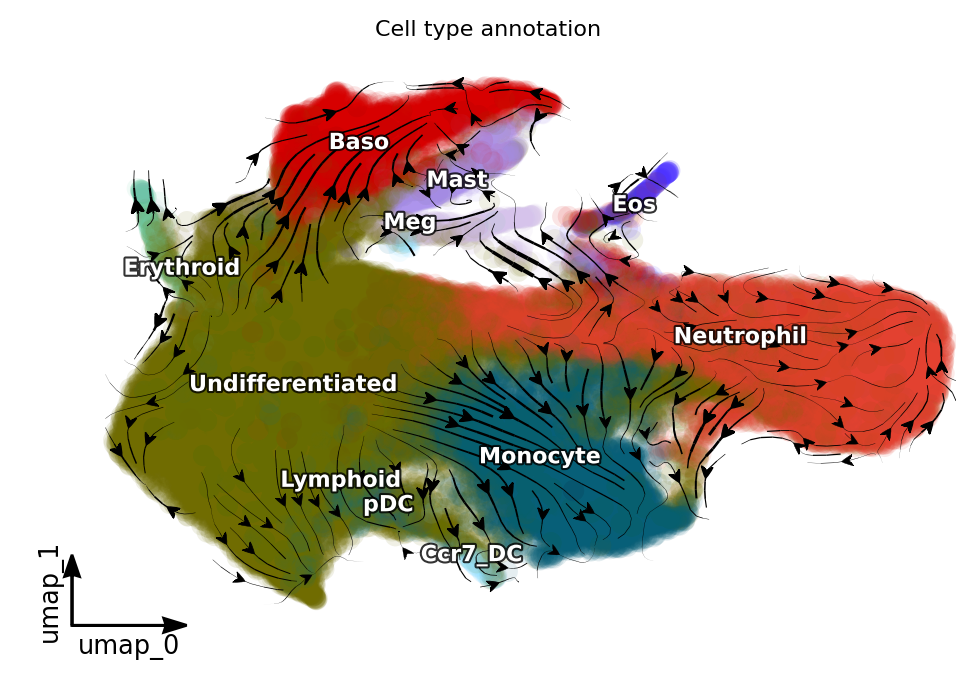

In [21]:
# visualize the streamline plot in the UMAP space (this will look different because we subsetted the cells)
dyn.tl.reduceDimension(adata_subset_velo, basis='umap', enforce=True)
dyn.pl.streamline_plot(adata_subset_velo, color=['Cell type annotation'], basis='umap', show_legend='on data', show_arrowed_spines=True)

In [22]:
# learn the vector field
dyn.vf.VectorField(adata_subset_velo, basis='pca', M=1000)

|-----> VectorField reconstruction begins...
|-----> Retrieve X and V based on basis: PCA. 
        Vector field will be learned in the PCA space.
|-----> Learning vector field with method: sparsevfc.
|-----> [SparseVFC] begins...
|-----> Sampling control points based on data velocity magnitude...
|-----> [SparseVFC] in progress: 100.0000%
|-----> [SparseVFC] finished [73.6753s]
|-----------> current cosine correlation between input velocities and learned velocities is less than 0.6. Make a 1-th vector field reconstruction trial.
|-----> [SparseVFC] begins...
|-----> Sampling control points based on data velocity magnitude...
|-----> [SparseVFC] in progress: 100.0000%
|-----> [SparseVFC] finished [69.9682s]
|-----------> current cosine correlation between input velocities and learned velocities is less than 0.6. Make a 2-th vector field reconstruction trial.
|-----> [SparseVFC] begins...
|-----> Sampling control points based on data velocity magnitude...
|-----> [SparseVFC] in progress

In [17]:
# integrate the cells 
fate_adata = dyn.pd.fate(adata_subset_velo, list(starting_names[0:500]), basis='pca', direction='forward')

uniformly sampling points along a trajectory: 100%|████████████████████████████████████████████████████████████████████| 500/500 [00:02<00:00, 233.77it/s]


In [19]:
# compute fate bias of these cells and save
output = dyn.pd.fate_bias(fate_adata, 'Cell type annotation', basis='pca')
output.to_csv(path_or_buf='LARRY_dynamo_bias_corrected_vel.csv')
output

calculating fate distributions: 500it [28:47,  3.45s/it]


,confidence,Baso,Ccr7_DC,Eos,Erythroid,Lymphoid,Mast,Meg,Monocyte,Neutrophil,Undifferentiated,pDC
d2_3:GCGCTGATTAGCCTCG-0,0.004082,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.074359,0.0,0.925641,0.000000
d2_3:CGTTGCCTCACAGTTT-0,0.004132,0.012821,0.0,0.0,0.000000,0.023077,0.0,0.000000,0.000000,0.0,0.961538,0.002564
d2_3:TCGTGGGTCGTCAGCA-0,0.004065,0.020513,0.0,0.0,0.048718,0.000000,0.0,0.000000,0.000000,0.0,0.930769,0.000000
d2_3:TGCGACTATAACCCGT-0,0.004115,0.000000,0.0,0.0,0.002564,0.000000,0.0,0.479487,0.000000,0.0,0.517949,0.000000
d2_3:GTTGTCCGTAACCATC-0,0.004049,0.217949,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.782051,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...
d2_2:GTCAGGTTATCAGCGC-0,0.004167,0.351282,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.648718,0.000000
d2_2:GCGGTAACGCTTACCT-0,0.004065,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.0,1.000000,0.000000
d2_2:GTCCTTGCAGCGCGAT-0,0.004065,0.115385,0.0,0.0,0.000000,0.000000,0.0,0.007692,0.000000,0.0,0.876923,0.000000
d2_2:TCATTTCACGCCTTGA-0,0.004149,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.0,1.000000,0.000000


In [24]:
# we can plot topography out of curiosity in the PCA space
dyn.pl.topography(adata_subset_velo, basis='pca')

|-----> Vector field for umap is not constructed. Constructing it and mapping its topography now ...
|-----> VectorField reconstruction begins...
|-----> Retrieve X and V based on basis: UMAP. 
        Vector field will be learned in the UMAP space.
|-----> Generating high dimensional grids and convert into a row matrix.
|-----> Learning vector field with method: sparsevfc.
|-----> [SparseVFC] begins...
|-----> Sampling control points based on data velocity magnitude...
|-----> [SparseVFC] in progress: 100.0000%
|-----> [SparseVFC] finished [886.7723s]
|-----------> current cosine correlation between input velocities and learned velocities is less than 0.6. Make a 1-th vector field reconstruction trial.
|-----> [SparseVFC] begins...
|-----> Sampling control points based on data velocity magnitude...
|-----> [SparseVFC] in progress: 100.0000%
|-----> [SparseVFC] finished [931.1009s]
|-----------> current cosine correlation between input velocities and learned velocities is less than 0.6

KeyboardInterrupt: 